1535


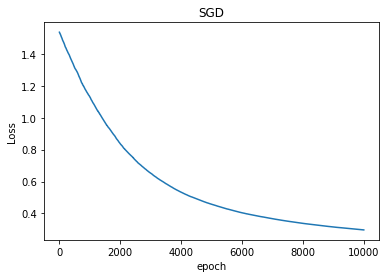

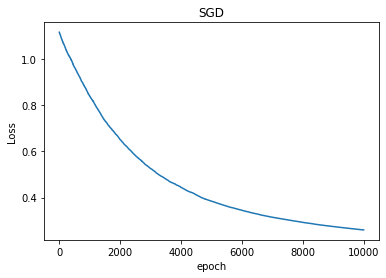

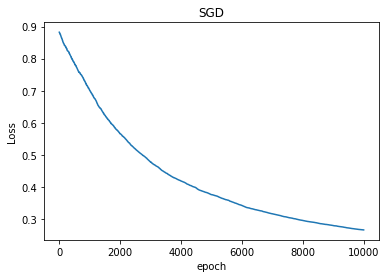

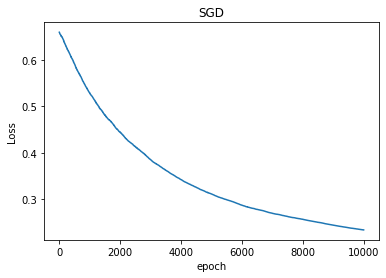

Accuracy between predicted and true values in dataset_train.csv: 97.78501628664495%



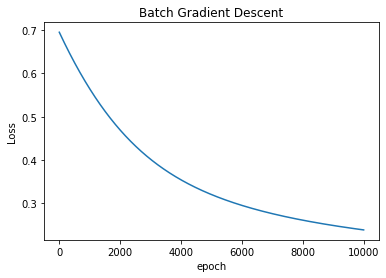

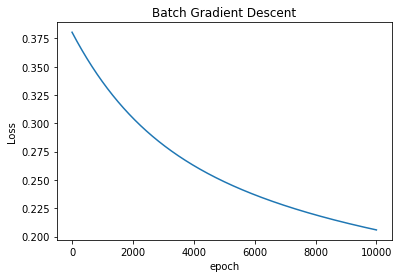

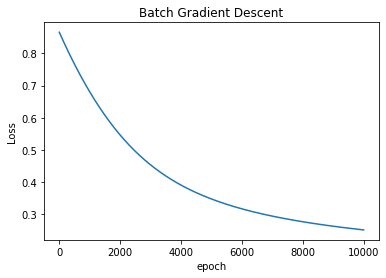

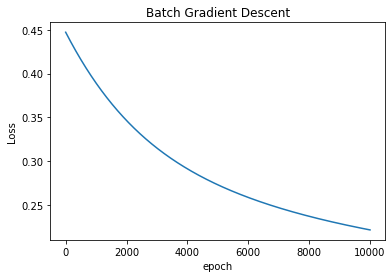

Accuracy between predicted and true values in dataset_train.csv: 98.0456026058632%



In [1]:
import numpy as np
import copy
from math import *
import sys
import matplotlib.pyplot as plt

def get_data(dataset):
    del_cols = set()
    save_labels = ['Hogwarts House', "Astronomy", "Herbology"]
    with open(dataset) as file:
        rows_list = file.read().splitlines()
        col_dict = {}
        labels = rows_list[0].split(',')
        for label in labels:
            col_dict[label] = []
            if label not in save_labels:
                del_cols.add(label)
        for row in rows_list[1:]:
            values = row.split(",")
            for index in range(len(col_dict)):
                col_dict[labels[index]].append(values[index])
    for key in del_cols:
        col_dict.pop(key)
    return col_dict

def drop_empty_vals(data):
    del_rows = set()
    tmp_data = {}
    tmp_data["Herbology"] = data["Herbology"]
    tmp_data["Astronomy"] = data["Astronomy"]
    del_rows = [ind_val for key, lst in tmp_data.items() for ind_val in range(len(lst)) if lst[ind_val] == '']
    new_data = {key:[] for key in data.keys()}
    for key, lst in data.items():
        for ind_val in range(len(lst)):
            if ind_val not in del_rows:
                new_data[key].append(lst[ind_val])
    return new_data

def convert_to_int(col_dict):
    for key, list_values in col_dict.items():
        col_dict[key] = [float(val) if key!='Hogwarts House' else val for val in list_values]

def add_int_col_for_house(data):
    data['House val'] = []
    houses = set()
    for val in data["Hogwarts House"]:
        houses.add(val)
    houses = list(houses)
    order_house = {}
    for ind_house in range(len(houses)):
        order_house[houses[ind_house]] = ind_house
    for ind_house in range(len(data["Hogwarts House"])):
        data['House val'].append(order_house[data["Hogwarts House"][ind_house]])
    return data, order_house

def mean(lst):
    return sum(lst) / len(lst)

def standart_deviation(np_feature, vals):
    return sqrt(np.sum(np.power(np_feature - mean(vals), 2)) / len(vals))

def normalize_data(features):
    for feature, vals in features.items():
        np_feature = np.array(vals)
        features[feature] = (np_feature - min(vals)) / (max(vals) - min(vals))
    return features

def  standartize_data(features):
    for feature, vals in features.items():
        np_feature = np.array(vals)
        features[feature] = (np_feature - mean(vals)) / standart_deviation(np_feature, vals)
    return features

def convert_int_to_classname(dict_house, y_pred1):
    y_pred1 = y_pred1.astype(str)
    for key, value in dict_house.items():
        y_pred1[y_pred1 == str(value)] = key
    return y_pred1

class Logistic:
    alpha = 0.001

    def _sigmoid_function(self, z):
        return 1 / (1 + np.exp(-z))

    def cost_function(self, X, y, w):
        m = y.size
        z = np.dot(w, X.T)
        matrix_sigm = self._sigmoid_function(z)
        log_sigmoid_1 = np.log(matrix_sigm)
        log_sigmoid_2 = np.log(1 - matrix_sigm)
        return (-1/m) * np.sum(np.dot((y).T,log_sigmoid_1) + np.dot((1 - y).T, (log_sigmoid_2)))

    def update_weights(self, X, y, weights_old):
        m = y.size
        z = np.dot(weights_old, X.T)
        sigm = self._sigmoid_function(z)
        gradient = np.dot(X.T, (sigm - y)) / m
        weights_new = weights_old - (self.alpha * gradient)
        return weights_new

    def fit(self, X, y, w, dict_house):
        list_w = []
        list_losses = []
        uniq_y = list(dict_house.values())
        dict_class_losses = {}
        
        #iterating each class
        for class_y in uniq_y:
            dict_class_losses[class_y] = []
            tmp_y = copy.deepcopy(y)

            #replacing value in curr class to 1, other to 0
            for ind_class_y in range(len(y)):
                if tmp_y[ind_class_y] == class_y:
                    tmp_y[ind_class_y] = 1
                else:
                    tmp_y[ind_class_y] = 0
            # min_loss = self.cost_function(X, tmp_y, w)
            # new_loss = self.cost_function(X, tmp_y, w)
            norm_weights = copy.deepcopy(w)
            new_weights = copy.deepcopy(w)            

            #updating weights
            for epoch in range(10000):
                new_weights = self.update_weights(X, tmp_y, new_weights)
                dict_class_losses[class_y].append(self.cost_function(X, tmp_y, new_weights))
            new_loss = self.cost_function(X, tmp_y, new_weights)
            list_w.append((new_weights, class_y))
            list_losses.append((new_loss, class_y))
        return list_w, list_losses, dict_class_losses

    def fit_sgd(self, X, y, w, dict_house, epoch = 10000):
        list_w, list_losses =  [], []
        dict_class_losses = {}

        # бегать по 4 классификаторам
            # выполнять обновление весов sgd
        uniq_y = list(dict_house.values())

        # #iterating each class
        for class_y in uniq_y:
            dict_class_losses[class_y] = []
            tmp_y = copy.deepcopy(y)
            for ind_class_y in range(len(y)):
                if tmp_y[ind_class_y] == class_y:
                    tmp_y[ind_class_y] = 1
                else:
                    tmp_y[ind_class_y] = 0
            new_weights = copy.deepcopy(w)  
            for _ in range(epoch):
                random_ind = np.random.randint(0, len(y) - 1)
                x_sample = X[random_ind]
                y_true = tmp_y[random_ind]  
                new_weights = self.update_weights(x_sample, y_true, new_weights)
                dict_class_losses[class_y].append(self.cost_function(X, tmp_y, new_weights))
            new_loss = self.cost_function(X, tmp_y, new_weights)
            list_w.append((new_weights, class_y))
            list_losses.append((new_loss, class_y))
        return list_w, list_losses, dict_class_losses

    def predict(self, data, X, list_w):
        pred_y = []
        
        # iter each sample for each possible weights(amount different triples of weights = amount of classes)
        # ind of max probability is predicted class(realization analogy of argmax)
        for ind_row in range(len(data["Hogwarts House"])):
            max_prob = None
            save_ind = None
            X_tmp = copy.deepcopy(X)
            for ind_w in range(len(list_w)):
                np_w = copy.deepcopy(np.array(list_w))
                wX = np.dot(X_tmp[ind_row], np_w[ind_w])
                sigm_probability = self._sigmoid_function(wX)
                if max_prob == None or max_prob < sigm_probability:
                    save_ind = ind_w
                    max_prob = sigm_probability
            pred_y.append(save_ind)
        pred_y = np.array(pred_y)
        return pred_y

    def score(self, data, X, list_w, y):
        y_pred = self.predict(data, X, list_w)
        length = len(y_pred)
        equals = 0
        for ind in range(length):
            if y_pred[ind] == y[ind]:
                equals += 1
        return f"Accuracy between predicted and true values in dataset_train.csv: {equals * 100 / length}%\n"

def prep_data(dataset):
    data = get_data(dataset)
    data = drop_empty_vals(data)

    data["f0"] = [1 for x in range(len(data["Hogwarts House"]))]

    # #it makes sence to change arounding
    convert_to_int(data)

    data, dict_house = add_int_col_for_house(data)
    standartized_data = standartize_data({"Herbology": data["Herbology"], "Astronomy": data["Astronomy"]})

    #matrix
    X = np.array([data["f0"], standartized_data["Herbology"], standartized_data["Astronomy"]]).T
    return data, dict_house, X

def train(data, dict_house, X):
    # #вектор
    # w = np.random.normal(0, 1, X.shape[1])
    w = np.array([-1.56335628, -0.44355203, -0.1269146])
    #vector
    y = np.array((data["House val"]))

    log_model = Logistic()
    tuple_w_class, list_losses, dict_class_losses = log_model.fit(X, y, w, dict_house)

    list_w = [w for w, cls in tuple_w_class]
    for val_list in dict_class_losses.values():
        plt.xlabel("epoch")
        plt.ylabel("Loss")
        plt.title("Batch Gradient Descent")
        plt.plot([x for x in range(10000)], val_list)
        plt.show()
    return data, X, list_w, dict_house, log_model, y


def train_sgd(data, dict_house, X):
    w = np.random.normal(0, 1, X.shape[1])
    #vector
    y = np.array((data["House val"]))

    log_model = Logistic()
    tuple_w_class, list_losses, dict_class_losses = log_model.fit_sgd(X, y, w, dict_house)

    list_w = [w for w, cls in tuple_w_class]
    
    for val_list in dict_class_losses.values():
        plt.xlabel("epoch")
        plt.ylabel("Loss")
        plt.title("SGD")
        plt.plot([x for x in range(10000)], val_list)
        plt.show()
    return data, X, list_w, dict_house, log_model, y

#tarin
def logreg_train(dataset, sgd = False):
    data, dict_house, X = prep_data(dataset)
    if sgd == False:
        data, X, list_w, dict_house, log_model, y = train(data, dict_house, X)
    else:
        data, X, list_w, dict_house, log_model, y = train_sgd(data, dict_house, X)
    y_pred1 = log_model.predict(data, X, list_w)

    print(log_model.score(data, X, list_w, y))
    
    y_pred1 = convert_int_to_classname(dict_house, y_pred1)
    return log_model, list_w, dict_house

#change answer, False: shows depending Loss of epoch in batch gradient descent, True: shows depending Loss of epoch in stochastic gradient descent
if __name__ == '__main__':
    answer = True
    _, _, _ = logreg_train("dataset_train.csv", answer)
    _, _, _ = logreg_train("dataset_train.csv", False)

